# ⚙️ Installazione delle dipendenze


In [1]:
!pip install transformers
!pip install -U accelerate > /dev/null 2>&1
!pip install -U datasets > /dev/null 2>&1
!pip install -U bertviz > /dev/null 2>&1
!pip install -U umap-learn > /dev/null 2>&1
!pip install seaborn --upgrade > /dev/null 2>&1
!pip install -U openpyxl > /dev/null 2>&1

import warnings
warnings.filterwarnings('ignore')


## 📥  Coding

In [2]:
import transformers

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/andreaFaccenda00/FakeNewsDetection-BERT/main/Dataset/fake_news.xlsx"

df = pd.read_excel(url)

In [4]:
df.isnull().sum()
df = df.dropna()

df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [5]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
import re, string
import nltk
from nltk.corpus import stopwords

try:
    _ = stopwords.words("english")
except LookupError:
    nltk.download("stopwords")

STOPWORDS = set(stopwords.words("english"))

URL_RE   = re.compile(r"https?://\S+|www\.\S+")
HTML_RE  = re.compile(r"<[^>]+>")
KEEP_PUNCT = r"\'#%:.;$=>\<\|\(\)\[\]\?\!\&\*\,"
NON_CHAR_RE = re.compile(fr"[^A-Za-z{KEEP_PUNCT}\s]+")
EMOJI_RE = re.compile(
    "["
    "\U0001F1E0-\U0001F1FF"
    "\U0001F300-\U0001F5FF"
    "\U0001F600-\U0001F64F"
    "\U0001F680-\U0001F6FF"
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FAFF"
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+"
)
MULTISPACE_RE = re.compile(r"\s{2,}")

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = URL_RE.sub(" ", text)
    text = HTML_RE.sub(" ", text)
    text = EMOJI_RE.sub(" ", text)
    text = NON_CHAR_RE.sub(" ", text)
    tokens = [
        tok for tok in text.split()
        if tok not in STOPWORDS
    ]
    text = " ".join(tokens)
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
df["title"] = df["title"].apply(clean_text)
df["text"] = df["text"].apply(clean_text)

In [8]:
df.shape

df['label'].value_counts()

,count
label,
0,10361
1,7920


## 🏷️  Dataset Analysis

In [9]:
import matplotlib.pyplot as plt

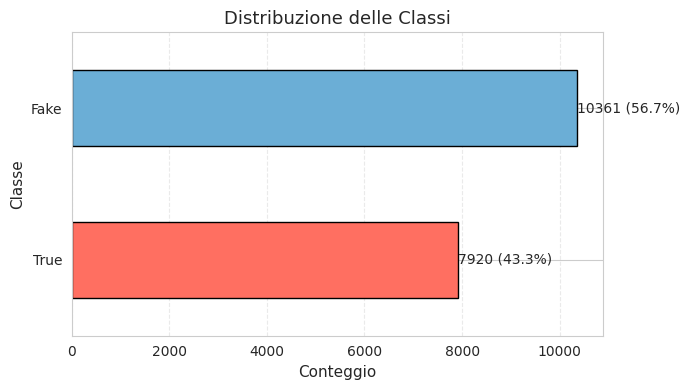

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

label_map = {0: "Fake", 1: "True"}
label_counts = df['label'].map(label_map).value_counts(ascending=True)

sns.set_style("whitegrid")
palette = ["#ff6f61", "#6baed6"]

plt.figure(figsize=(7, 4))
ax = label_counts.plot.barh(color=palette, edgecolor="black")

for i, (value, label) in enumerate(zip(label_counts, label_counts.index)):
    plt.text(value + 1, i, f"{value} ({value/sum(label_counts)*100:.1f}%)", va="center", fontsize=10)

plt.xlabel("Conteggio", fontsize=11)
plt.ylabel("Classe", fontsize=11)
plt.title("Distribuzione delle Classi", fontsize=13)
plt.grid(True, axis='x', linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


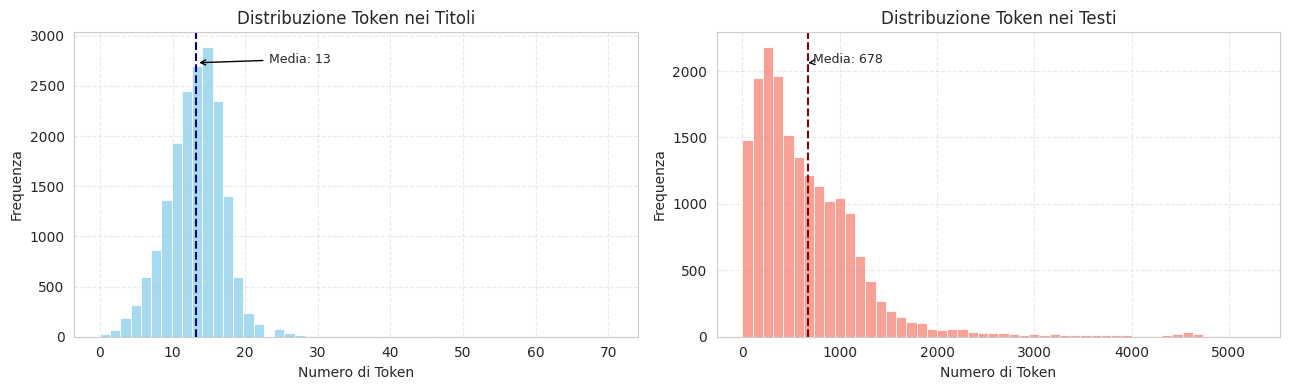

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

df['title_tokens'] = df['title'].apply(lambda x: len(str(x).split()) * 1.5)
df['text_tokens'] = df['text'].apply(lambda x: len(str(x).split()) * 1.5)

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

sns.histplot(df["title_tokens"], bins=50, ax=ax[0], color="skyblue", edgecolor="white")
mean_title = df["title_tokens"].mean()
ax[0].axvline(mean_title, linestyle="--", color="darkblue", linewidth=1.5)
ax[0].annotate(f"Media: {mean_title:.0f}", xy=(mean_title, ax[0].get_ylim()[1]*0.9),
               xytext=(mean_title+10, ax[0].get_ylim()[1]*0.9),
               arrowprops=dict(arrowstyle="->", color="black"), fontsize=9)
ax[0].set_title("Distribuzione Token nei Titoli", fontsize=12)
ax[0].set_xlabel("Numero di Token", fontsize=10)
ax[0].set_ylabel("Frequenza", fontsize=10)

sns.histplot(df["text_tokens"], bins=50, ax=ax[1], color="salmon", edgecolor="white")
mean_text = df["text_tokens"].mean()
ax[1].axvline(mean_text, linestyle="--", color="darkred", linewidth=1.5)
ax[1].annotate(f"Media: {mean_text:.0f}", xy=(mean_text, ax[1].get_ylim()[1]*0.9),
               xytext=(mean_text+50, ax[1].get_ylim()[1]*0.9),
               arrowprops=dict(arrowstyle="->", color="black"), fontsize=9)
ax[1].set_title("Distribuzione Token nei Testi", fontsize=12)
ax[1].set_xlabel("Numero di Token", fontsize=10)
ax[1].set_ylabel("Frequenza", fontsize=10)

for a in ax:
    a.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


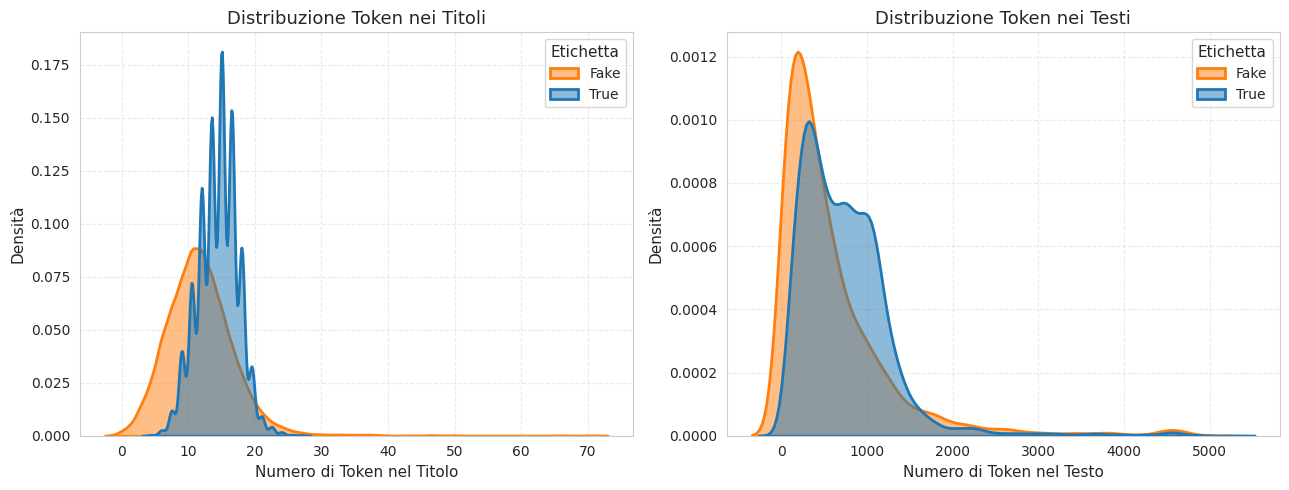

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

sns.kdeplot(
    data=df,
    x="title_tokens",
    hue="label",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=2,
    ax=ax[0]
)
ax[0].set_title("Distribuzione Token nei Titoli", fontsize=13, weight="normal")
ax[0].set_xlabel("Numero di Token nel Titolo", fontsize=11)
ax[0].set_ylabel("Densità", fontsize=11)
ax[0].legend(title="Etichetta", labels=["Fake", "True"], fontsize=10, title_fontsize=11, loc="upper right")
ax[0].grid(True, linestyle="--", alpha=0.4)

sns.kdeplot(
    data=df,
    x="text_tokens",
    hue="label",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=2,
    ax=ax[1]
)
ax[1].set_title("Distribuzione Token nei Testi", fontsize=13, weight="normal")
ax[1].set_xlabel("Numero di Token nel Testo", fontsize=11)
ax[1].set_ylabel("Densità", fontsize=11)
ax[1].legend(title="Etichetta", labels=["Fake", "True"], fontsize=10, title_fontsize=11, loc="upper right")
ax[1].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


## ⚙️  Split in Train/Test/Validation

In [13]:
from sklearn.model_selection import train_test_split

# 70% for training, 20% test, 10% validation
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape



((12796, 7), (3656, 7), (1829, 7), (18281, 7))

In [14]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

## 🏷️ Data Tokenization

In [15]:
from transformers import AutoTokenizer


model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
def tokenize(batch):
    temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 2763, 2196, 8828, 2613, 8038, 2213, 1010, 102, 0, 0, 0], [101, 8922, 2982, 2081, 1024, 25736, 13250, 27759, 2047, 2259, 2335, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [17]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

## Model Building

In [61]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_ckpt = "distilbert-base-uncased"


num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.53.0",
  "vocab_size": 30522
}

## 🛠️ Fine-Tuning

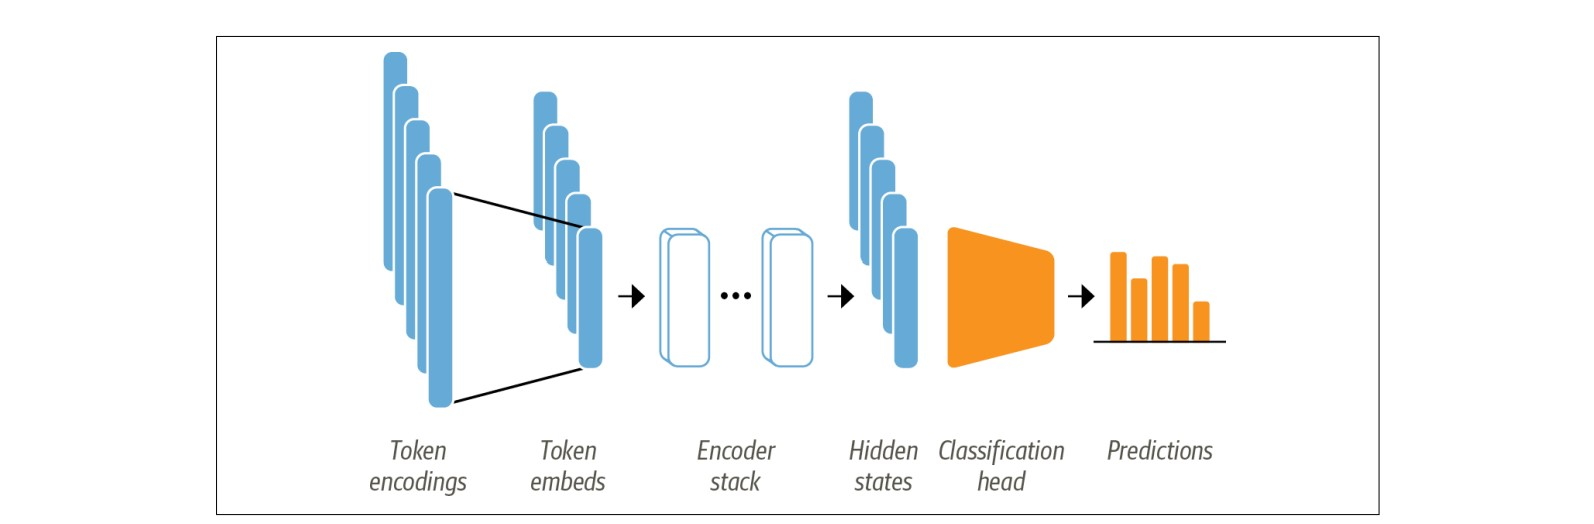


In [63]:
!pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [64]:
import numpy as np, torch, evaluate
from transformers import (
    AutoConfig, AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer,
    EarlyStoppingCallback, IntervalStrategy
)

MODEL_NAME          = "distlbert-base-uncased"
FREEZE_LAYERS       = 3
NUM_EPOCHS          = 4
BATCH_SIZE          = 16
GRAD_ACCUM_STEPS    = 2
LR                  = 2e-5
WARMUP_RATIO        = 0.1
WEIGHT_DECAY        = 0.01
DROP_PROB           = 0.2
LABEL_SMOOTHING     = 0.1
EARLYSTOP_PATIENCE  = 1
SEED                = 42

tokenizer = distilbert_tokenizer
model     = model

for layer in model.distilbert.transformer.layer[:FREEZE_LAYERS]:
    for p in layer.parameters():
        p.requires_grad = False

data_collator = DataCollatorWithPadding(tokenizer)

accuracy = evaluate.load("accuracy")
f1_macro = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    f1  = f1_macro.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1": f1}

training_args = TrainingArguments(
    output_dir                   = "BERT_Fake_News_Detection",
    overwrite_output_dir         = True,
    num_train_epochs             = NUM_EPOCHS,
    learning_rate                = LR,
    warmup_ratio                 = WARMUP_RATIO,
    lr_scheduler_type            = "cosine",
    per_device_train_batch_size  = BATCH_SIZE,
    per_device_eval_batch_size   = BATCH_SIZE,
    gradient_accumulation_steps  = GRAD_ACCUM_STEPS,
    weight_decay                 = WEIGHT_DECAY,
    label_smoothing_factor       = LABEL_SMOOTHING,
    eval_strategy                = IntervalStrategy.EPOCH,
    logging_strategy             = IntervalStrategy.EPOCH,
    save_strategy                = IntervalStrategy.EPOCH,
    load_best_model_at_end       = True,
    metric_for_best_model        = "eval_loss",
    greater_is_better            = False,
    report_to                    = [],
    seed                         = SEED,
)

callbacks = [EarlyStoppingCallback(
    early_stopping_patience      = EARLYSTOP_PATIENCE,
    early_stopping_threshold     = 0.0
)]

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = encoded_dataset["train"],
    eval_dataset    = encoded_dataset["validation"],
    tokenizer       = tokenizer,
    data_collator   = data_collator,
    compute_metrics = compute_metrics,
    callbacks       = callbacks,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.395500,0.306100,0.930016,0.928651
2,0.282300,0.294957,0.942045,0.941233
3,0.254900,0.298686,0.934390,0.933131


TrainOutput(global_step=1200, training_loss=0.3109178606669108, metrics={'train_runtime': 325.8807, 'train_samples_per_second': 157.064, 'train_steps_per_second': 4.91, 'total_flos': 814419915952608.0, 'train_loss': 0.3109178606669108, 'epoch': 3.0})

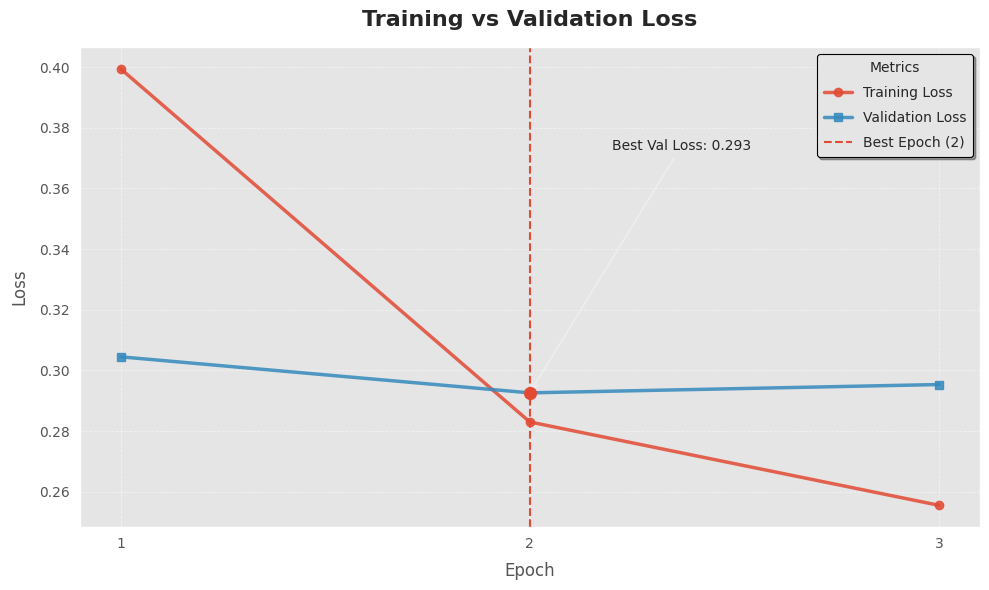

In [58]:
import matplotlib.pyplot as plt
import numpy as np

history       = trainer.state.log_history
train_loss    = [log["loss"]       for log in history if "loss"       in log]
eval_loss     = [log["eval_loss"]  for log in history if "eval_loss"  in log]
epochs        = list(range(1, len(eval_loss) + 1))

best_epoch    = int(np.argmin(eval_loss)) + 1
best_val_loss = eval_loss[best_epoch - 1]

fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

ax.plot(
    epochs, train_loss,
    label="Training Loss",
    linewidth=2.5, marker="o", markersize=6, alpha=0.85
)
ax.plot(
    epochs, eval_loss,
    label="Validation Loss",
    linewidth=2.5, marker="s", markersize=6, alpha=0.85
)

ax.axvline(
    best_epoch, linestyle="--", linewidth=1.5,
    label=f"Best Epoch ({best_epoch})"
)
ax.scatter([best_epoch], [best_val_loss], s=80, zorder=5)

ax.annotate(
    f"Best Val Loss: {best_val_loss:.3f}",
    xy=(best_epoch, best_val_loss),
    xytext=(best_epoch + 0.2, best_val_loss + 0.08),
    arrowprops=dict(arrowstyle="->", linewidth=1.2),
    fontsize=10, ha="left"
)

ax.set_title("Training vs Validation Loss", fontsize=16, weight="bold", pad=15)
ax.set_xlabel("Epoch", fontsize=12, labelpad=8)
ax.set_ylabel("Loss", fontsize=12, labelpad=8)
ax.set_xticks(epochs)

ax.grid(which='major', linestyle='--', linewidth=0.6, alpha=0.5)
ax.minorticks_off()

legend = ax.legend(
    title="Metrics",
    title_fontsize=10,
    fontsize=10,
    loc="upper right",
    frameon=True,
    fancybox=True,
    shadow=True,
    borderpad=0.5,
    labelspacing=0.8,
    handlelength=2,
    handletextpad=0.8
)
frame = legend.get_frame()
frame.set_edgecolor("black")
frame.set_linewidth(0.8)

plt.tight_layout()
plt.show()


## 📊 Valutazione del Modello

📄 Report di classificazione:

              precision    recall  f1-score   support

        Real       0.95      0.93      0.94      2072
        Fake       0.91      0.94      0.92      1584

    accuracy                           0.93      3656
   macro avg       0.93      0.93      0.93      3656
weighted avg       0.93      0.93      0.93      3656



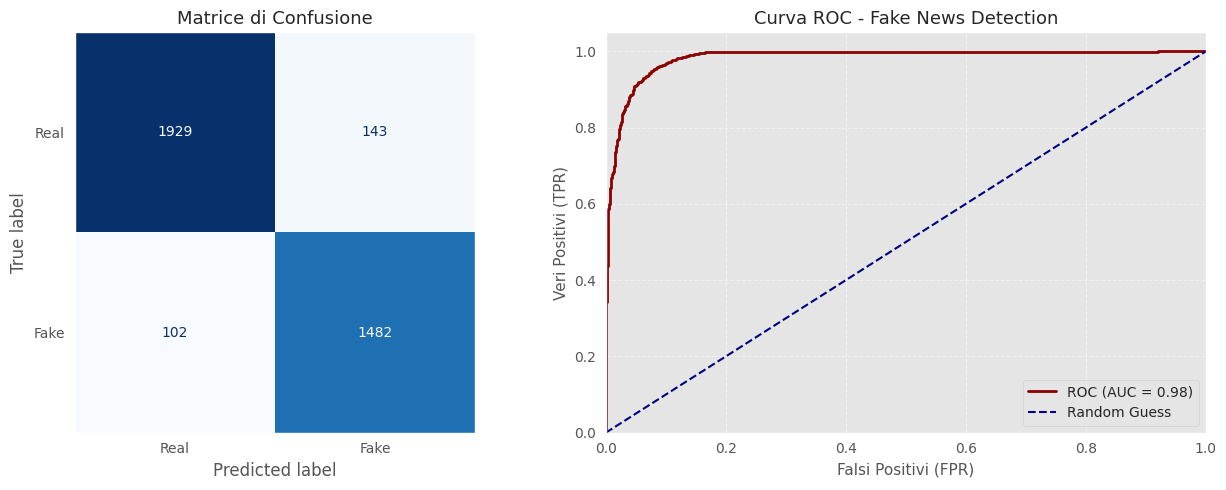

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

plt.style.use("ggplot")

preds_output = trainer.predict(encoded_dataset["test"])
y_true = encoded_dataset["test"]["label"]
y_pred = np.argmax(preds_output.predictions, axis=1)

print("📄 Report di classificazione:\n")
print(classification_report(y_true, y_pred, target_names=list(label2id)))

cm = confusion_matrix(y_true, y_pred)
disp_labels = list(label2id.keys())

y_scores = preds_output.predictions[:, 1]
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)
disp.plot(ax=ax1, cmap="Blues", values_format="d", colorbar=False)
ax1.set_title("Matrice di Confusione", fontsize=13)
ax1.grid(False)

ax2.plot(fpr, tpr, color="darkred", lw=2, label=f"ROC (AUC = {roc_auc:.2f})")
ax2.plot([0, 1], [0, 1], color="navy", lw=1.5, linestyle="--", label="Random Guess")
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel("Falsi Positivi (FPR)", fontsize=11)
ax2.set_ylabel("Veri Positivi (TPR)", fontsize=11)
ax2.set_title("Curva ROC - Fake News Detection", fontsize=13)
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

## 💾 12. Salvataggio del modello

In [37]:
from google.colab import drive

drive.mount("/content/drive")

save_path = '/content/drive/MyDrive/Data Science/BERT_Fake_News_Detection/fake_news'
trainer.save_model(save_path)

Mounted at /content/drive


## 🔁 13. Caricamento del modello addestrato

In [38]:
from transformers import pipeline

classifier = pipeline(
    task='text-classification',
    model=save_path,
)

Device set to use cuda:0


## 🧪 14. Esempio di inferenza

In [67]:
from transformers import pipeline
import pandas as pd
from IPython.display import display

# 1. Costruisci la pipeline partendo dal Trainer addestrato
classifier = pipeline(
    task="text-classification",
    model=trainer.model,
    tokenizer=tokenizer,          # usa direttamente la tua variabile tokenizer
    return_all_scores=True,
    function_to_apply="softmax",
    device=0
)

unseen_news_text = [
    "Scientists Discover Potential Cure for Common Cold",
    "Secret Government Illuminati Meeting Held Underground"
]
actual_types = ["Real", "Fake"]

results = classifier(unseen_news_text)

pred_labels = [max(scores, key=lambda x: x["score"])["label"] for scores in results]
pred_scores = [f"{max(scores, key=lambda x: x['score'])['score']:.2%}" for scores in results]

df_preds = pd.DataFrame({
    "📰 Titolo":            unseen_news_text,
    "🔖 Tipo (vero/fake)":  actual_types,
    "✅ Predizione":        pred_labels,
    "📊 Confidence":        pred_scores
})

pd.set_option('display.max_colwidth', None)
styled = (
    df_preds
    .style
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'left')]
    }])
    .set_properties(**{'text-align': 'left'})
)
display(styled)


Device set to use cuda:0


,📰 Titolo,🔖 Tipo (vero/fake),✅ Predizione,📊 Confidence
0,Scientists Discover Potential Cure for Common Cold,Real,Fake,94.74%
1,Secret Government Illuminati Meeting Held Underground,Fake,Fake,89.83%


## 📊 15. Benchmarking

In [60]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoConfig, AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer,
    EarlyStoppingCallback, IntervalStrategy
)

MODEL_NAMES = [
    "bert-base-uncased",
    "roberta-base",
    "albert-base-v2",
    "google/mobilebert-uncased"
]
FREEZE_LAYERS      = 3
NUM_EPOCHS         = 4
BATCH_SIZE         = 16
GRAD_ACCUM_STEPS   = 2
LR                 = 2e-5
WARMUP_RATIO       = 0.1
WEIGHT_DECAY       = 0.01
LABEL_SMOOTHING    = 0.1
EARLYSTOP_PATIENCE = 1
SEED               = 42

results = []

for model_name in MODEL_NAMES:
    # 1) Config, tokenizer e modello
    config    = AutoConfig.from_pretrained(model_name, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model     = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

    # 2) Freeze layers
    if hasattr(model, "distilbert"):
        layers = model.distilbert.transformer.layer
    elif hasattr(model, "bert"):
        layers = model.bert.encoder.layer
    elif hasattr(model, "roberta"):
        layers = model.roberta.encoder.layer
    elif hasattr(model, "albert"):
        layers = model.albert.encoder.albert_layer_groups
    else:
        layers = []
    for layer in layers[:FREEZE_LAYERS]:
        for p in layer.parameters():
            p.requires_grad = False

    # 3) Trainer
    data_collator = DataCollatorWithPadding(tokenizer)
    training_args = TrainingArguments(
        output_dir=f"outputs/{model_name.replace('/', '_')}",
        overwrite_output_dir=True,
        num_train_epochs=NUM_EPOCHS,
        learning_rate=LR,
        warmup_ratio=WARMUP_RATIO,
        lr_scheduler_type="cosine",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=GRAD_ACCUM_STEPS,
        weight_decay=WEIGHT_DECAY,
        label_smoothing_factor=LABEL_SMOOTHING,
        eval_strategy=IntervalStrategy.EPOCH,
        logging_strategy=IntervalStrategy.EPOCH,
        save_strategy=IntervalStrategy.EPOCH,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],
        seed=SEED
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda pred: {
            "accuracy": accuracy_score(pred.label_ids, np.argmax(pred.predictions, axis=-1)),
            "f1": f1_score(pred.label_ids, np.argmax(pred.predictions, axis=-1), average="macro")
        },
        callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLYSTOP_PATIENCE)]
    )

    # 4) Timing training
    start_train = time.perf_counter()
    trainer.train()
    train_time = time.perf_counter() - start_train

    # 5) Timing inferenza sul test set
    start_inf = time.perf_counter()
    preds_output = trainer.predict(encoded_dataset["test"])
    inf_time = time.perf_counter() - start_inf

    # 6) Metriche finali
    preds  = np.argmax(preds_output.predictions, axis=-1)
    labels = preds_output.label_ids
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")

    results.append({
        "model": model_name,
        "train_time_sec":      round(train_time, 1),
        "inference_time_sec":  round(inf_time, 1),
        "accuracy":            round(acc, 4),
        "f1_macro":            round(f1, 4)
    })

# 7) Tabella riassuntiva
df_results = pd.DataFrame(results).set_index("model")
print(df_results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.380800,0.334106,0.906506,0.903078
2,0.279900,0.290151,0.944232,0.943279
3,0.241200,0.294124,0.944779,0.943530


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.436100,0.352316,0.899945,0.899772
2,0.348700,0.338710,0.906506,0.905767
3,0.323800,0.343310,0.903226,0.901383


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.551000,0.426953,0.864407,0.863451
2,0.395700,0.393568,0.893931,0.893712
3,0.379300,0.375808,0.896665,0.896486
4,0.367300,0.377331,0.896118,0.895934


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,289283.400000,4181.058105,0.851285,0.851279


model.safetensors:   0%|          | 0.00/147M [00:00<?, ?B/s]

KeyboardInterrupt: 